## Question 1

We will first try SFM using the original implementation from $\mathtt{libviso2}$. We will test on a dataset contains 300 images from one sequence of KITTI dataset with ground-truth camera poses and camera calibration information. Run the SFM algorithm using the following script. You are required to report two error metrics. The error metric for rotation is defined as the mean of Frobenius norm of the difference between the ground-truth rotation matrix and predicted rotation matrix. The error metric for translation is defined as mean of the L2 distance. Both errors will be printed on the screen as you run the code. 

In [1]:
import os
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
import viso2
import matplotlib.pyplot as plt
from skimage.io import imread
import time

def errorMetric(RPred, RGt, TPred, TGt):
    diffRot = (RPred - RGt)
    diffTrans = (TPred - TGt)
    errorRot = np.sqrt(np.sum(np.multiply(diffRot.reshape(-1), diffRot.reshape(-1))))
    errorTrans = np.sqrt(np.sum(np.multiply(diffTrans.reshape(-1), diffTrans.reshape(-1))))

    return errorRot, errorTrans

if_vis = True # set to True to do the visualization per frame; the images will be saved at '.vis/'. Turn off if you just want the camera poses and errors
if_on_screen = False # if True the visualization per frame is going to be displayed realtime on screen; if False there will be no display, but in both options the images will be saved

# parameter settings (for an example, please download
# dataset_path = '../dataset'
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM' # On the ``ieng6.ucsd.edu`` server
img_dir      = os.path.join(dataset_path, 'sequences/00/image_0')
gt_dir       = os.path.join(dataset_path, 'poses/00.txt')
calibFile    = os.path.join(dataset_path, 'sequences/00/calib.txt')
border       = 50;
gap          = 15;

# Load the camera calibration information
with open(calibFile) as fid:
    calibLines = fid.readlines()
    calibLines = [calibLine.strip() for calibLine in calibLines]

calibInfo = [float(calibStr) for calibStr in calibLines[0].split(' ')[1:]]
# param = {'f': calibInfo[0], 'cu': calibInfo[2], 'cv': calibInfo[6]}

# Load the ground-truth depth and rotation
with open(gt_dir) as fid:
    gtTr = [[float(TrStr) for TrStr in line.strip().split(' ')] for line in fid.readlines()]
gtTr = np.asarray(gtTr).reshape(-1, 3, 4)

# param['height'] = 1.6
# param['pitch']  = -0.08
# param['match'] = {'pre_step_size': 64}
first_frame  = 0
last_frame   = 300
epi = 1e-8

# init visual odometry
params = viso2.Mono_parameters()
params.calib.f = calibInfo[0]
params.calib.cu = calibInfo[2]
params.calib.cv = calibInfo[6]
params.height = 1.6
params.pitch = -0.08


first_frame  = 0
last_frame   = 300

# init transformation matrix array
Tr_total = []
Tr_total_np = []
Tr_total.append(viso2.Matrix_eye(4))
Tr_total_np.append(np.eye(4))

# init viso module
visoMono = viso2.VisualOdometryMono(params)

if if_vis:
    save_path = 'vis'
    os.makedirs(save_path, exist_ok=True)

    # create figure
    fig = plt.figure(figsize=(10, 15))
    ax1 = plt.subplot(211)
    ax1.axis('off')
    ax2 = plt.subplot(212)
    ax2.set_xticks(np.arange(-100, 100, step=10))
    ax2.set_yticks(np.arange(-500, 500, step=10))
    ax2.axis('equal')
    ax2.grid()
    if if_on_screen:
        plt.ion()
    else:
        plt.ioff()

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/cse152-252-sp20-public/dataset_SfM/sequences/00/calib.txt'

Mean Error Rotation: 6947558.55240
Mean Error Translation: 9718750861.05217
== [Result] Frame: 0, Matches 0, Inliers: 0.00
Saved at vis/frame000.jpg


<Figure size 432x288 with 0 Axes>

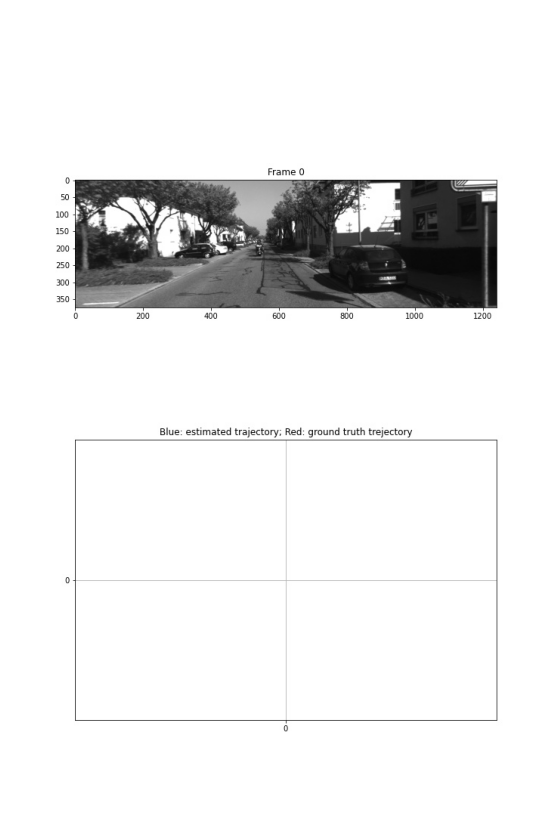

[[ 1.     -0.0016 -0.003  -0.0052]
 [ 0.0016  1.     -0.0021 -0.0045]
 [ 0.003   0.0021  1.      0.4767]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.07306
Mean Error Translation: 97.57250
== [Result] Frame: 1, Matches 320, Inliers: 89.69
Saved at vis/frame001.jpg
[[ 1.     -0.0011 -0.0079 -0.0057]
 [ 0.0011  1.     -0.0036 -0.0085]
 [ 0.0079  0.0036  1.      0.9479]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.03858
Mean Error Translation: 48.98120
== [Result] Frame: 2, Matches 325, Inliers: 83.38
Saved at vis/frame002.jpg
[[ 0.9999 -0.0021 -0.0123 -0.0119]
 [ 0.002   1.     -0.0046 -0.0159]
 [ 0.0123  0.0046  0.9999  1.4281]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02701
Mean Error Translation: 32.78121
== [Result] Frame: 3, Matches 329, Inliers: 83.59
Saved at vis/frame003.jpg
[[ 0.9998 -0.0029 -0.0179 -0.0188]
 [ 0.0028  1.     -0.0051 -0.0207]
 [ 0.018   0.0051  0.9998  1.9135]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0

Mean Error Rotation: 0.00535
Mean Error Translation: 3.52610
== [Result] Frame: 30, Matches 300, Inliers: 77.67
Saved at vis/frame030.jpg
[[ 0.998   0.0108 -0.0626 -1.0344]
 [-0.0111  0.9999 -0.0052 -0.209 ]
 [ 0.0626  0.0059  0.998  18.7213]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00522
Mean Error Translation: 3.41969
== [Result] Frame: 31, Matches 290, Inliers: 82.76
Saved at vis/frame031.jpg
[[ 0.9981  0.0102 -0.0612 -1.0813]
 [-0.0107  0.9999 -0.0079 -0.2198]
 [ 0.0611  0.0085  0.9981 19.4001]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00510
Mean Error Translation: 3.32158
== [Result] Frame: 32, Matches 303, Inliers: 81.52
Saved at vis/frame032.jpg
[[ 0.9981  0.0071 -0.0607 -1.1221]
 [-0.0076  0.9999 -0.0069 -0.2301]
 [ 0.0606  0.0074  0.9981 20.0676]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00498
Mean Error Translation: 3.23006
== [Result] Frame: 33, Matches 280, Inliers: 80.36
Saved at vis/frame033.jpg
[[ 0.9981  0.0072 -0.0609

In [ ]:
# for all frames do
if_replace = False
errorTransSum = 0
errorRotSum = 0
errorRot_list = []
errorTrans_list =[]

for frame in range(first_frame, last_frame):
    # 1-based index
    k = frame-first_frame+1

    # read current images
    I = imread(os.path.join(img_dir, '%06d.png'%frame))
    assert(len(I.shape) == 2) # should be grayscale

    # compute egomotion
    process_result = visoMono.process_frame(I, if_replace)
    Tr = visoMono.getMotion()
    matrixer = viso2.Matrix(Tr)
    Tr_np = np.zeros((4, 4))
    Tr.toNumpy(Tr_np) # so awkward...

    # accumulate egomotion, starting with second frame
    if k > 1:
        if process_result is False:
            if_replace = True
            Tr_total.append(Tr_total[-1])
            Tr_total_np.append(Tr_total_np[-1])
        else:
            if_replace = False
            Tr_total.append(Tr_total[-1] * viso2.Matrix_inv(Tr))
            Tr_total_np.append(Tr_total_np[-1] @ np.linalg.inv(Tr_np)) # should be the same
            print(Tr_total_np[-1])

    # output statistics
    num_matches = visoMono.getNumberOfMatches()
    num_inliers = visoMono.getNumberOfInliers()
    matches = visoMono.getMatches()
    matches_np = np.empty([4, matches.size()])

    for i,m in enumerate(matches):
        matches_np[:, i] = (m.u1p, m.v1p, m.u1c, m.v1c)

    if if_vis:
        # update image
        ax1.clear()
        ax1.imshow(I, cmap='gray', vmin=0, vmax=255)
        if num_matches != 0:
            for n in range(num_matches):
                ax1.plot([matches_np[0, n], matches_np[2, n]], [matches_np[1, n], matches_np[3, n]])
        ax1.set_title('Frame %d'%frame)

        # update trajectory
        if k > 1:
            ax2.plot([Tr_total_np[k-2][0, 3], Tr_total_np[k-1][0, 3]], \
                [Tr_total_np[k-2][2, 3], Tr_total_np[k-1][2, 3]], 'b.-', linewidth=1)
            ax2.plot([gtTr[k-2][0, 3], gtTr[k-1][0, 3]], \
                [gtTr[k-2][2, 3], gtTr[k-1][2, 3]], 'r.-', linewidth=1)
        ax2.set_title('Blue: estimated trajectory; Red: ground truth trejectory')

        plt.draw()

    # Compute rotation
    Rpred_p = Tr_total_np[k-2][0:3, 0:3]
    Rpred_c = Tr_total_np[k-1][0:3, 0:3]
    Rpred = Rpred_c.transpose() @ Rpred_p
    Rgt_p = np.squeeze(gtTr[k-2, 0:3, 0:3])
    Rgt_c = np.squeeze(gtTr[k-1, 0:3, 0:3])
    Rgt = Rgt_c.transpose() @ Rgt_p
    # Compute translation
    Tpred_p = Tr_total_np[k-2][0:3, 3:4]
    Tpred_c = Tr_total_np[k-1][0:3, 3:4]
    Tpred = Tpred_c - Tpred_p
    Tgt_p = gtTr[k-2, 0:3, 3:4]
    Tgt_c = gtTr[k-1, 0:3, 3:4]
    Tgt = Tgt_c - Tgt_p
    # Compute errors
    errorRot, errorTrans = errorMetric(Rpred, Rgt, Tpred, Tgt)
    errorRotSum = errorRotSum + errorRot
    errorTransSum = errorTransSum + errorTrans
    # errorRot_list.append(errorRot)
    # errorTrans_list.append(errorTrans)
    print('Mean Error Rotation: %.5f'%(errorRotSum / (k-1+epi)))
    print('Mean Error Translation: %.5f'%(errorTransSum / (k-1+epi)))



    print('== [Result] Frame: %d, Matches %d, Inliers: %.2f'%(frame, num_matches, 100*num_inliers/(num_matches+1e-8)))

    if if_vis:
        # input('Paused; Press Enter to continue') # Option 1: Manually pause and resume
        if if_on_screen:
            plt.pause(0.1) # Or Option 2: enable to this to auto pause for a while after daring to enable animation in case of a delay in drawing
        vis_path = os.path.join(save_path, 'frame%03d.jpg'%frame)
        fig.savefig(vis_path)
        print('Saved at %s'%vis_path)
        
        if frame % 50 == 0 or frame == last_frame-1:
            plt.figure(figsize=(10, 15))
            plt.imshow(plt.imread(vis_path))
            plt.axis('off')
            plt.show()


# input('Press Enter to exit')

Answer the questions below

1. In $\mathtt{libviso2}$, the feature points are "bucketed" ($\mathtt{libviso2/src/matcher.cpp: Line 285 - 326}$), which means in a certain area of region, the number of detected keypoint pairs should be within certain bounds. Why? 

2. We have run SFM on a single camera, which means the scale of translation is unknown. However, as you may have observed, the predicted trajectory is still somehow similar to the ground-truth trajectory. How does $\mathtt{libviso2}$ handle this ambiguity ($\mathtt{viso\_mono.cpp: Line 175}$)? 

3. Briefly explain the RANSAC algorithm used in $\mathtt{libviso2}$ ($\mathtt{viso\_mono.cpp: Line 91 - 105}$). 

## Question 2

In the second task, you are required to use keypoints and feature descriptors from SIFT for SFM. The SIFT implementation can be found in directory $\mathtt{SIFT}$. 
1. Go to $\mathtt{SIFT}$ directory and run $\mathtt{runSIFT.py}$ (e.g. `python runSIFT.py --input /datasets/cse152-252-sp20-pubc/dataset_SfM/sequences/00/image_0/`). You will save the detected keypoints and feature descriptors under the directory $\mathtt{SIFT}$. For image $\mathtt{000abc.png}$, the pre-computed features and keypoints should be saved in a $\mathtt{.npy}$ file named as $\mathtt{000abc\_feature.npy}$. The variable should be a $130 \times N$ matrix with $\mathtt{single}$ precision, where $N$ is the number of feature points being detected. For each $130$-dimensional feature vector, the first two dimensions are the location of the keypoints (column number first and then row number) on the image plane and the last $128$ dimensions are the feature descriptor. 
2. Run the following script

/Users/zhengqinli/Desktop/HW1_py/cse252c_hw1/pyviso/runFeature.py:176: RuntimeWarning: divide by zero encountered in double_scalars
  print('Mean Error Rotation: %.5f'%(errorRotSum / (k-1)))
/Users/zhengqinli/Desktop/HW1_py/cse252c_hw1/pyviso/runFeature.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  print('Mean Error Translation: %.5f'%(errorTransSum / (k-1)))


Mean Error Rotation: inf
Mean Error Translation: inf
== [Result] Frame: 0, Matches 0, Inliers: 0.00
Saved at vis_preFeature/frame000.jpg


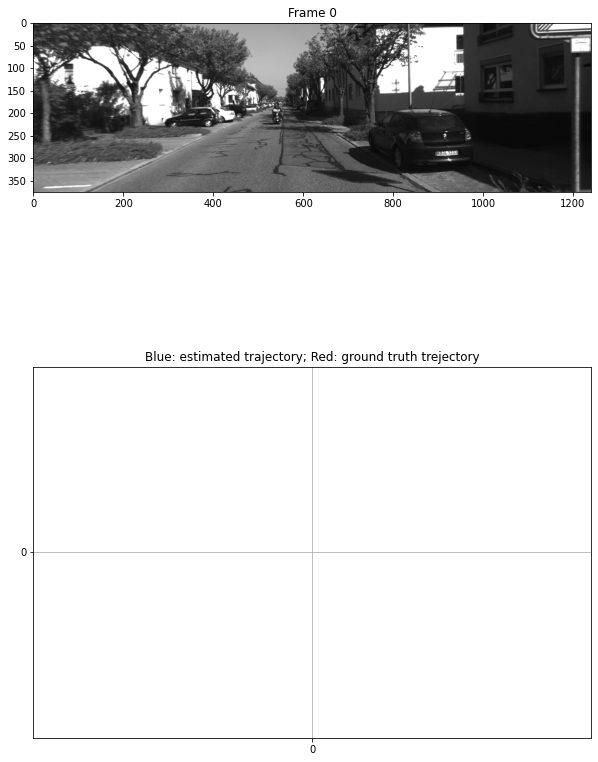

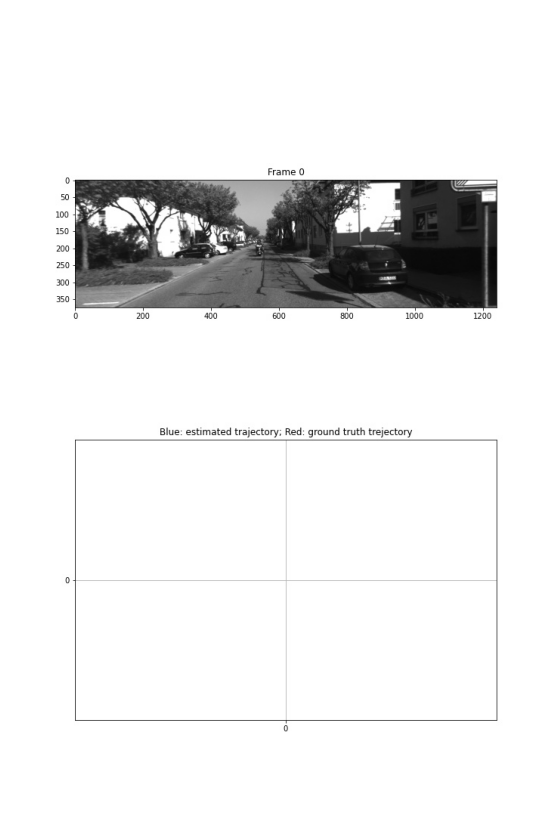

[[ 1.     -0.0029 -0.0034 -0.0001]
 [ 0.0029  1.     -0.002  -0.0037]
 [ 0.0034  0.002   1.      0.4568]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.07476
Mean Error Translation: 97.59291
== [Result] Frame: 1, Matches 282, Inliers: 78.37
Saved at vis_preFeature/frame001.jpg
[[ 1.     -0.0008 -0.007  -0.0103]
 [ 0.0008  1.     -0.0037 -0.005 ]
 [ 0.007   0.0037  1.      0.9047]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.03895
Mean Error Translation: 49.00252
== [Result] Frame: 2, Matches 281, Inliers: 72.95
Saved at vis_preFeature/frame002.jpg
[[ 0.9999 -0.0005 -0.0105 -0.0225]
 [ 0.0004  1.     -0.0053 -0.007 ]
 [ 0.0105  0.0053  0.9999  1.3662]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02668
Mean Error Translation: 32.80154
== [Result] Frame: 3, Matches 292, Inliers: 77.40
Saved at vis_preFeature/frame003.jpg
[[ 0.9999  0.0004 -0.0157 -0.0314]
 [-0.0005  1.     -0.006  -0.0107]
 [ 0.0157  0.006   0.9999  1.8592]
 [ 0.      0.      0.    

In [ ]:
import runFeature
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'SIFT'
runFeature.runSFM(dataset_path, feature_dir )

Next, answer the following questions:

1. Does SIFT yield higher accuracy than the original {\tt libviso2}? If so, why? If not, what steps can you take to improve?

2. Explain how SIFT achieves invariance to 
       a. illumination
       b. rotation
       c. scale

## Question 3

Now you are required to use keypoints and feature descriptors from SuperPoint for SFM. The code for the trained model of this method can be found from the $\mathtt{SuperPoint}$.
1. Go to $\mathtt{SuperPoint}$ directory and run $\mathtt{demo\_superpoint.py}$. The detected keypoints and feature descriptors are under the directory $\mathtt{SuperPoint}$. The file format is similar to the SIFT case. For image $\mathtt{000abc.png}$, the pre-computed features and keypoints should be saved in a $\mathtt{.npy}$ file named as $\mathtt{000abc\_feature.npy}$. The variable is a $258\times N$ matrix with $\mathtt{single}$ precision, where $N$ is the number of feature points being detected. For each $258$-dimensional feature vector, the first two dimensions are the locations of the keypoint (column number first and then row number) on the image plane and the last $256$ dimensions represent the feature descriptor. 
2. Run the following script

/Users/zhengqinli/Desktop/HW1_py/cse252c_hw1/pyviso/runFeature.py:176: RuntimeWarning: divide by zero encountered in double_scalars
  print('Mean Error Rotation: %.5f'%(errorRotSum / (k-1)))
/Users/zhengqinli/Desktop/HW1_py/cse252c_hw1/pyviso/runFeature.py:177: RuntimeWarning: divide by zero encountered in double_scalars
  print('Mean Error Translation: %.5f'%(errorTransSum / (k-1)))


Mean Error Rotation: inf
Mean Error Translation: inf
== [Result] Frame: 0, Matches 0, Inliers: 0.00
Saved at vis_preFeature/frame000.jpg


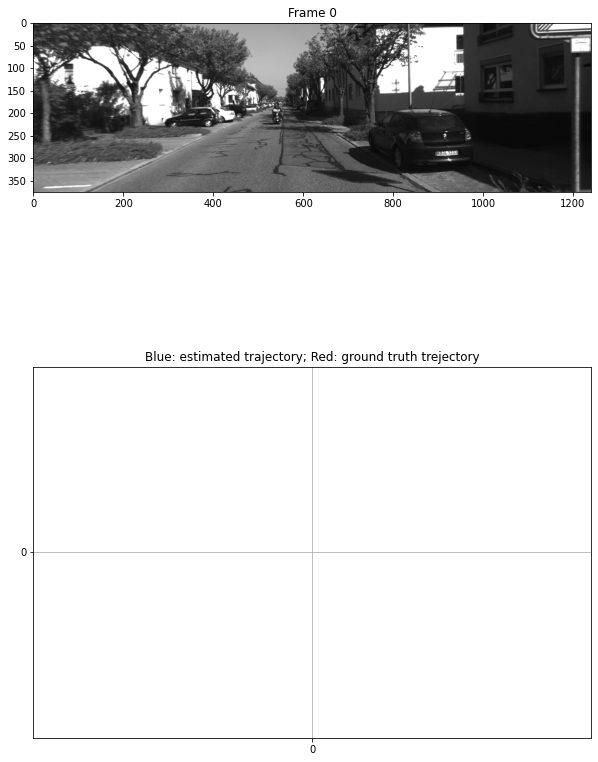

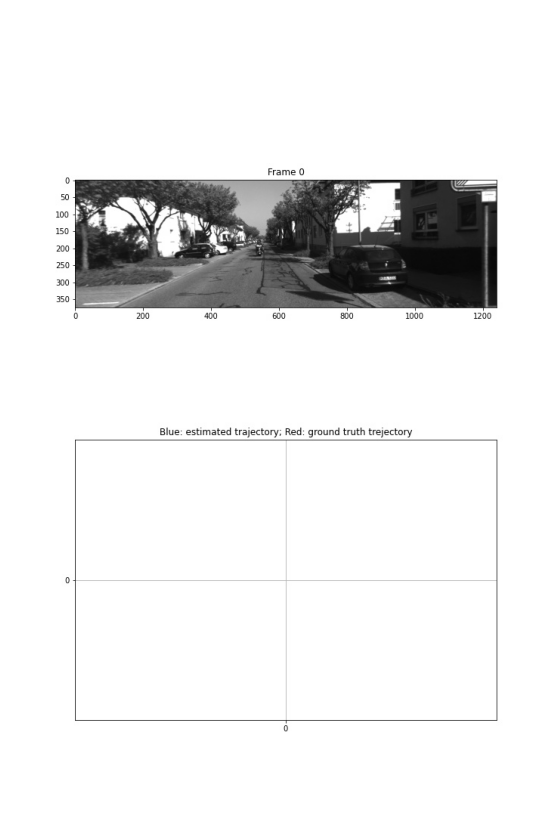

[[ 1.     -0.0029 -0.0034 -0.0001]
 [ 0.0029  1.     -0.002  -0.0037]
 [ 0.0034  0.002   1.      0.4568]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.07476
Mean Error Translation: 97.59291
== [Result] Frame: 1, Matches 282, Inliers: 78.37
Saved at vis_preFeature/frame001.jpg
[[ 1.     -0.0008 -0.007  -0.0103]
 [ 0.0008  1.     -0.0037 -0.005 ]
 [ 0.007   0.0037  1.      0.9047]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.03895
Mean Error Translation: 49.00252
== [Result] Frame: 2, Matches 281, Inliers: 72.95
Saved at vis_preFeature/frame002.jpg
[[ 0.9999 -0.0005 -0.0105 -0.0225]
 [ 0.0004  1.     -0.0053 -0.007 ]
 [ 0.0105  0.0053  0.9999  1.3662]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02668
Mean Error Translation: 32.80154
== [Result] Frame: 3, Matches 292, Inliers: 77.40
Saved at vis_preFeature/frame003.jpg
[[ 0.9999  0.0004 -0.0157 -0.0314]
 [-0.0005  1.     -0.006  -0.0107]
 [ 0.0157  0.006   0.9999  1.8592]
 [ 0.      0.      0.    

Mean Error Rotation: 0.00520
Mean Error Translation: 3.65080
== [Result] Frame: 29, Matches 251, Inliers: 73.31
Saved at vis_preFeature/frame029.jpg
[[ 0.9982  0.0072 -0.0596 -0.9039]
 [-0.0071  1.      0.0017 -0.192 ]
 [ 0.0596 -0.0012  0.9982 17.6506]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00507
Mean Error Translation: 3.53767
== [Result] Frame: 30, Matches 247, Inliers: 78.14
Saved at vis_preFeature/frame030.jpg
[[ 0.9983  0.0095 -0.0576 -0.9581]
 [-0.0097  0.9999 -0.0034 -0.1974]
 [ 0.0575  0.0039  0.9983 18.3383]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00499
Mean Error Translation: 3.43209
== [Result] Frame: 31, Matches 236, Inliers: 65.25
Saved at vis_preFeature/frame031.jpg
[[ 0.9983  0.0093 -0.0567 -0.9947]
 [-0.0097  0.9999 -0.0067 -0.2035]
 [ 0.0566  0.0072  0.9984 19.0057]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00486
Mean Error Translation: 3.33397
== [Result] Frame: 32, Matches 233, Inliers: 71.24
Saved at vis_preFe

<Figure size 432x288 with 0 Axes>

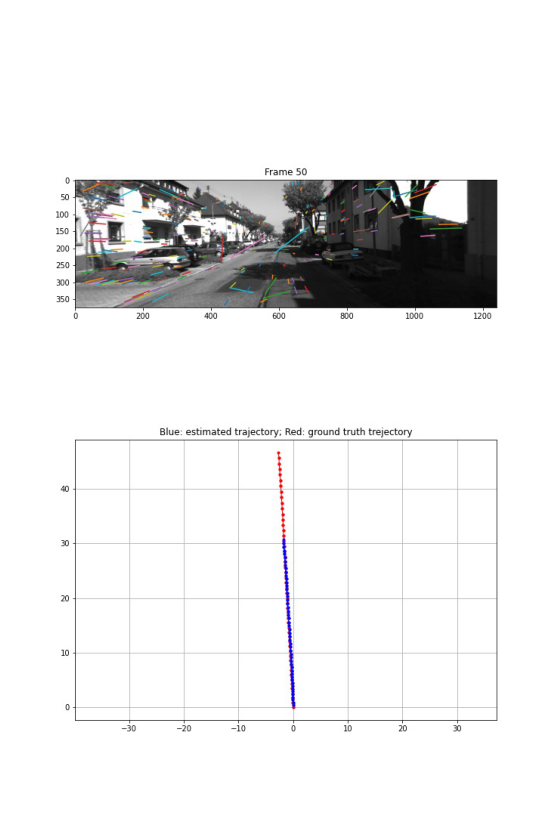

[[ 0.9976  0.0084 -0.069  -1.8423]
 [-0.0081  1.      0.0049 -0.3437]
 [ 0.0691 -0.0044  0.9976 31.4412]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00363
Mean Error Translation: 2.22397
== [Result] Frame: 51, Matches 247, Inliers: 72.47
Saved at vis_preFeature/frame051.jpg
[[ 0.9975  0.0098 -0.07   -1.89  ]
 [-0.0097  1.      0.0013 -0.3529]
 [ 0.07   -0.0006  0.9975 32.1403]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00362
Mean Error Translation: 2.18675
== [Result] Frame: 52, Matches 242, Inliers: 77.69
Saved at vis_preFeature/frame052.jpg
[[ 0.9974  0.0094 -0.0713 -1.9432]
 [-0.0097  0.9999 -0.0029 -0.3596]
 [ 0.0713  0.0036  0.9975 32.8614]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00359
Mean Error Translation: 2.15037
== [Result] Frame: 53, Matches 257, Inliers: 80.16
Saved at vis_preFeature/frame053.jpg
[[ 0.9973  0.0094 -0.0723 -1.9964]
 [-0.0097  0.9999 -0.0046 -0.3652]
 [ 0.0722  0.0053  0.9974 33.5765]
 [ 0.      0.      0.    

Mean Error Rotation: 0.00295
Mean Error Translation: 1.51800
== [Result] Frame: 79, Matches 273, Inliers: 83.88
Saved at vis_preFeature/frame079.jpg
[[ 0.9944  0.0099 -0.105  -3.4572]
 [-0.0106  0.9999 -0.0068 -0.6031]
 [ 0.1049  0.0079  0.9944 50.6973]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00293
Mean Error Translation: 1.50109
== [Result] Frame: 80, Matches 287, Inliers: 84.67
Saved at vis_preFeature/frame080.jpg
[[ 0.9944  0.01   -0.1055 -3.5153]
 [-0.0109  0.9999 -0.0082 -0.6088]
 [ 0.1055  0.0093  0.9944 51.2102]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00292
Mean Error Translation: 1.48482
== [Result] Frame: 81, Matches 293, Inliers: 82.94
Saved at vis_preFeature/frame081.jpg
[[ 0.9941  0.0106 -0.1077 -3.5613]
 [-0.0111  0.9999 -0.0045 -0.6209]
 [ 0.1077  0.0057  0.9942 51.7058]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00292
Mean Error Translation: 1.46893
== [Result] Frame: 82, Matches 302, Inliers: 83.11
Saved at vis_preFe

<Figure size 432x288 with 0 Axes>

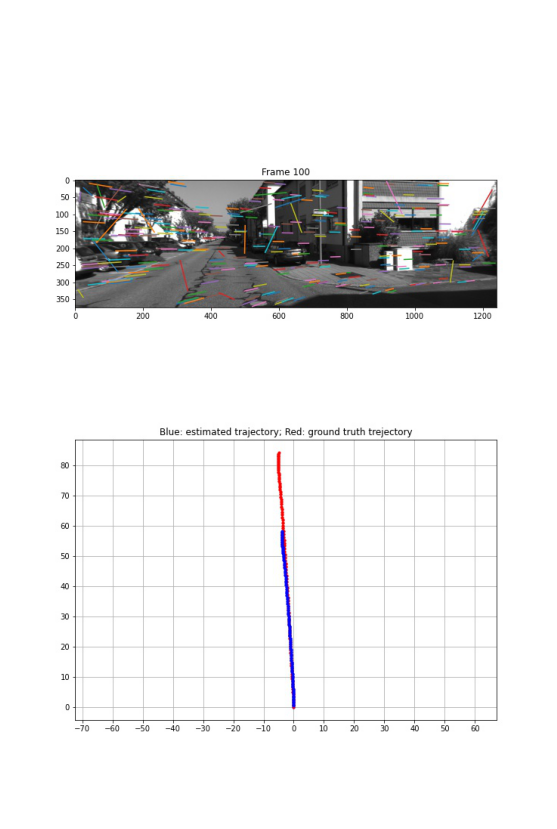

[[ 0.9806  0.0002  0.1962 -3.6884]
 [-0.0011  1.      0.0044 -0.7669]
 [-0.1962 -0.0045  0.9806 58.7409]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00272
Mean Error Translation: 1.22110
== [Result] Frame: 101, Matches 304, Inliers: 80.26
Saved at vis_preFeature/frame101.jpg
[[ 0.9699  0.0003  0.2436 -3.5761]
 [-0.0009  1.      0.0027 -0.7744]
 [-0.2436 -0.0028  0.9699 59.0384]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00272
Mean Error Translation: 1.21007
== [Result] Frame: 102, Matches 296, Inliers: 90.20
Saved at vis_preFeature/frame102.jpg
[[ 0.9554 -0.0005  0.2955 -3.4496]
 [ 0.0005  1.      0.     -0.7788]
 [-0.2955  0.0001  0.9554 59.3257]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00271
Mean Error Translation: 1.19933
== [Result] Frame: 103, Matches 303, Inliers: 85.81
Saved at vis_preFeature/frame103.jpg
[[ 0.9371 -0.0029  0.3492 -3.2987]
 [ 0.0037  1.     -0.0016 -0.7847]
 [-0.3492  0.0028  0.9371 59.5939]
 [ 0.      0.      0. 

Mean Error Rotation: 0.00256
Mean Error Translation: 1.01287
== [Result] Frame: 129, Matches 290, Inliers: 62.76
Saved at vis_preFeature/frame129.jpg
[[ 0.1172 -0.0023  0.9931 14.8956]
 [ 0.0377  0.9993 -0.0022 -0.9453]
 [-0.9924  0.0377  0.1172 64.2113]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00255
Mean Error Translation: 1.04120
== [Result] Frame: 130, Matches 285, Inliers: 62.11
Saved at vis_preFeature/frame130.jpg
[[ 0.1057 -0.0032  0.9944 15.243 ]
 [ 0.0407  0.9992 -0.0011 -0.9494]
 [-0.9936  0.0406  0.1057 64.2409]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00254
Mean Error Translation: 1.03441
== [Result] Frame: 131, Matches 282, Inliers: 68.44
Saved at vis_preFeature/frame131.jpg
[[ 0.0956 -0.0023  0.9954 15.6175]
 [ 0.0423  0.9991 -0.0018 -0.9518]
 [-0.9945  0.0423  0.0956 64.2724]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00254
Mean Error Translation: 1.02764
== [Result] Frame: 132, Matches 296, Inliers: 70.95
Saved at vis_p

<Figure size 432x288 with 0 Axes>

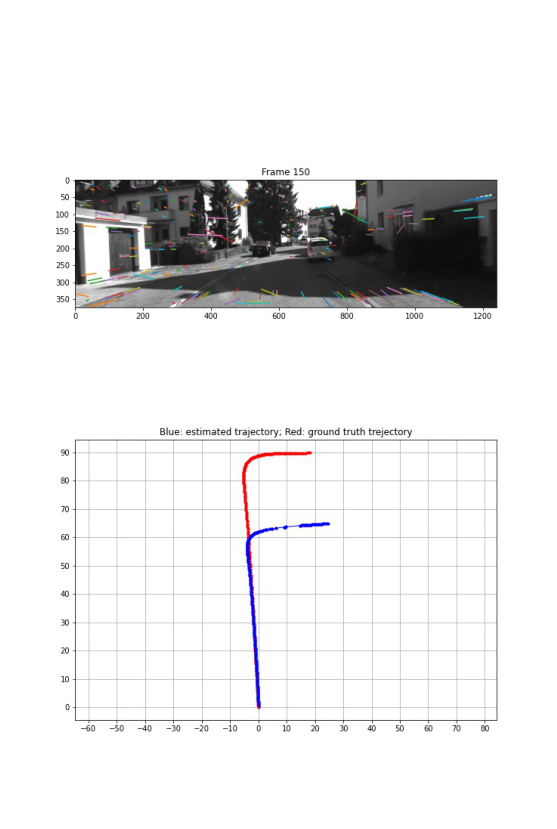

[[ 0.0889 -0.0026  0.996  25.229 ]
 [ 0.0546  0.9985 -0.0022 -1.0155]
 [-0.9945  0.0546  0.0889 64.9863]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00240
Mean Error Translation: 0.92094
== [Result] Frame: 151, Matches 209, Inliers: 78.47
Saved at vis_preFeature/frame151.jpg
[[ 0.091   0.0028  0.9958 25.8498]
 [ 0.0496  0.9987 -0.0074 -1.0236]
 [-0.9946  0.05    0.0907 65.0402]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00240
Mean Error Translation: 0.91612
== [Result] Frame: 152, Matches 216, Inliers: 77.78
Saved at vis_preFeature/frame152.jpg
[[ 0.0912  0.0061  0.9958 26.3903]
 [ 0.0471  0.9988 -0.0104 -1.0309]
 [-0.9947  0.0478  0.0908 65.0928]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00239
Mean Error Translation: 0.91192
== [Result] Frame: 153, Matches 217, Inliers: 83.41
Saved at vis_preFeature/frame153.jpg
[[ 0.0912  0.0061  0.9958 26.9754]
 [ 0.0443  0.999  -0.0102 -1.0384]
 [-0.9948  0.045   0.0909 65.1553]
 [ 0.      0.      0. 

Mean Error Rotation: 0.00230
Mean Error Translation: 0.81296
== [Result] Frame: 179, Matches 214, Inliers: 75.70
Saved at vis_preFeature/frame179.jpg
[[-0.0634 -0.0004  0.998  47.4393]
 [ 0.0456  0.999   0.0033 -1.3291]
 [-0.9969  0.0457 -0.0634 65.6947]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00229
Mean Error Translation: 0.80945
== [Result] Frame: 180, Matches 222, Inliers: 75.68
Saved at vis_preFeature/frame180.jpg
[[-0.068  -0.0023  0.9977 47.9648]
 [ 0.0477  0.9988  0.0056 -1.3366]
 [-0.9965  0.048  -0.0678 65.6613]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00229
Mean Error Translation: 0.80607
== [Result] Frame: 181, Matches 211, Inliers: 78.67
Saved at vis_preFeature/frame181.jpg
[[-0.0703 -0.0035  0.9975 48.4928]
 [ 0.0503  0.9987  0.007  -1.341 ]
 [-0.9963  0.0507 -0.07   65.6218]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00228
Mean Error Translation: 0.80263
== [Result] Frame: 182, Matches 206, Inliers: 73.30
Saved at vis_p

<Figure size 432x288 with 0 Axes>

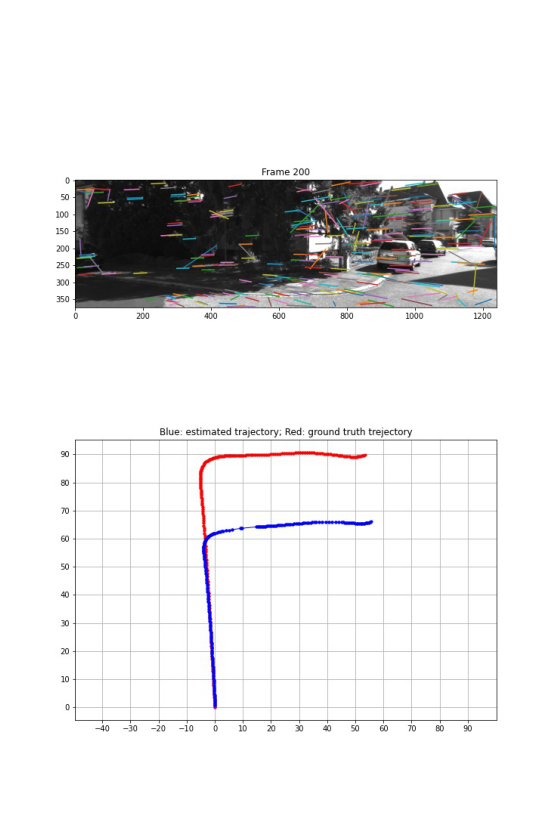

[[ 0.3647 -0.0019  0.9311 56.11  ]
 [ 0.0272  0.9996 -0.0086 -1.4833]
 [-0.9307  0.0285  0.3646 66.2716]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00224
Mean Error Translation: 0.74209
== [Result] Frame: 201, Matches 271, Inliers: 74.17
Saved at vis_preFeature/frame201.jpg
[[ 0.4217 -0.0017  0.9067 56.4378]
 [ 0.0301  0.9995 -0.0121 -1.4961]
 [-0.9062  0.0324  0.4216 66.4495]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00223
Mean Error Translation: 0.73902
== [Result] Frame: 202, Matches 277, Inliers: 72.92
Saved at vis_preFeature/frame202.jpg
[[ 0.4806  0.003   0.8769 56.7599]
 [ 0.03    0.9994 -0.0198 -1.5001]
 [-0.8764  0.0358  0.4802 66.6547]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00224
Mean Error Translation: 0.73583
== [Result] Frame: 203, Matches 269, Inliers: 58.74
Saved at vis_preFeature/frame203.jpg
[[ 0.5345  0.0078  0.8451 57.0167]
 [ 0.0277  0.9993 -0.0267 -1.5203]
 [-0.8447  0.0377  0.5339 66.9012]
 [ 0.      0.      0. 

Saved at vis_preFeature/frame229.jpg
[[ 0.9741  0.0514  0.2204 60.3548]
 [-0.0469  0.9986 -0.0256 -1.8473]
 [-0.2214  0.0147  0.9751 78.4395]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00226
Mean Error Translation: 0.66485
== [Result] Frame: 230, Matches 225, Inliers: 76.00
Saved at vis_preFeature/frame230.jpg
[[ 0.9732  0.0478  0.2248 60.4792]
 [-0.0443  0.9988 -0.0203 -1.8638]
 [-0.2255  0.0098  0.9742 78.9738]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00226
Mean Error Translation: 0.66235
== [Result] Frame: 231, Matches 213, Inliers: 73.24
Saved at vis_preFeature/frame231.jpg
[[ 0.9724  0.0459  0.2289 60.6217]
 [-0.0433  0.9989 -0.016  -1.878 ]
 [-0.2294  0.0057  0.9733 79.5847]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00225
Mean Error Translation: 0.65962
== [Result] Frame: 232, Matches 219, Inliers: 77.17
Saved at vis_preFeature/frame232.jpg
[[ 0.9717  0.0429  0.2325 60.7945]
 [-0.0404  0.9991 -0.0157 -1.8925]
 [-0.2329  0.0059  0

<Figure size 432x288 with 0 Axes>

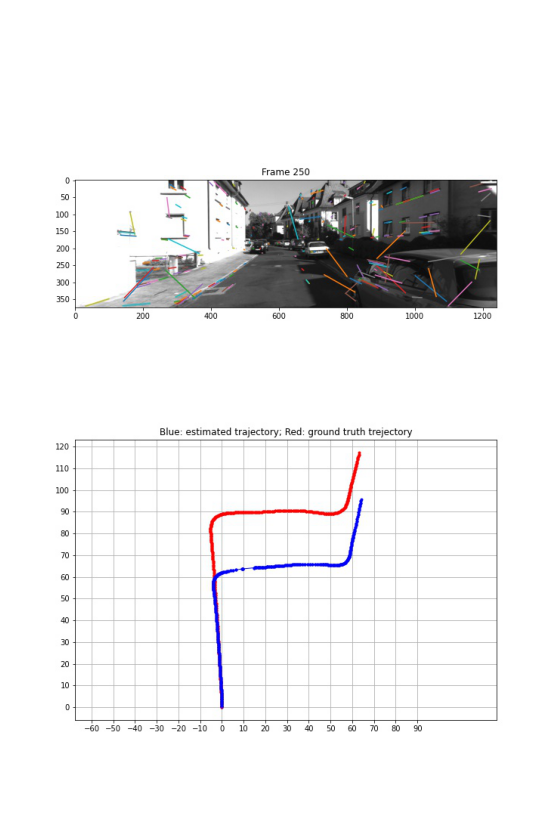

[[ 0.978   0.0431  0.2042 64.1803]
 [-0.0392  0.999  -0.0232 -2.4119]
 [-0.205   0.0147  0.9787 96.1057]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00220
Mean Error Translation: 0.62609
== [Result] Frame: 251, Matches 211, Inliers: 77.73
Saved at vis_preFeature/frame251.jpg
[[ 0.9776  0.0487  0.2049 64.2949]
 [-0.0441  0.9987 -0.0267 -2.4295]
 [-0.2059  0.0171  0.9784 96.7172]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00220
Mean Error Translation: 0.62449
== [Result] Frame: 252, Matches 221, Inliers: 83.26
Saved at vis_preFeature/frame252.jpg
[[ 0.9773  0.0558  0.2044 64.4213]
 [-0.051   0.9983 -0.0286 -2.447 ]
 [-0.2057  0.0176  0.9785 97.3186]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00220
Mean Error Translation: 0.62294
== [Result] Frame: 253, Matches 210, Inliers: 84.29
Saved at vis_preFeature/frame253.jpg
[[ 0.9766  0.06    0.2067 64.5466]
 [-0.0554  0.9981 -0.028  -2.4723]
 [-0.208   0.0159  0.978  97.9237]
 [ 0.      0.      0. 

Saved at vis_preFeature/frame278.jpg
[[  0.9766   0.0715   0.2027  68.4374]
 [ -0.0665   0.9973  -0.0317  -3.2225]
 [ -0.2044   0.0175   0.9787 116.7052]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00225
Mean Error Translation: 0.57855
== [Result] Frame: 279, Matches 203, Inliers: 71.92
Saved at vis_preFeature/frame279.jpg
[[  0.9768   0.0707   0.2022  68.6013]
 [ -0.0666   0.9974  -0.0269  -3.2577]
 [ -0.2036   0.0128   0.979  117.5749]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00225
Mean Error Translation: 0.57674
== [Result] Frame: 280, Matches 214, Inliers: 67.29
Saved at vis_preFeature/frame280.jpg
[[  0.9768   0.0709   0.2023  68.7606]
 [ -0.0667   0.9974  -0.0275  -3.2894]
 [ -0.2037   0.0133   0.9789 118.4598]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00225
Mean Error Translation: 0.57502
== [Result] Frame: 281, Matches 215, Inliers: 70.23
Saved at vis_preFeature/frame281.jpg
[[  0.9776   0.0678   0.1994  68.956 ]
 [ 

<Figure size 432x288 with 0 Axes>

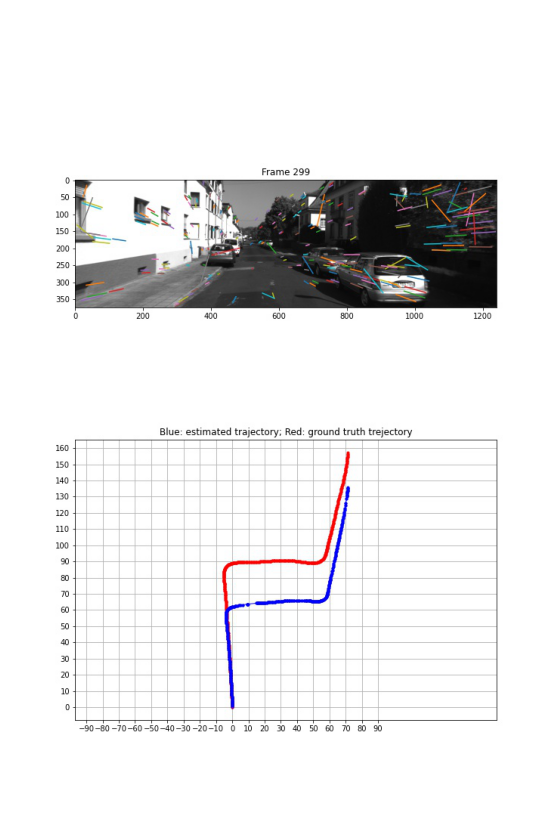

In [1]:
import runFeature
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'SuperPoint'
runFeature.runSFM(dataset_path, feature_dir )

Next, answer the following questions:

1. Does SuperPoint yield higher accuracy than the original $\mathtt{libviso2}$? If so, why? If not, what steps can you take to improve?

2. Explain briefly how the following issues are being handled in SuperPoint:
       a. Obtaining ground truth for keypoints.
       b. Cheaply obtaining accurate ground truth matches, as compared to LIDAR in UCN or SFM in LIFT.
       c. Learning a correlated feature representation for keypoint detection and description? 

## Question 4

Now we will compute camera motion from optical flow computed using SPyNet. We first uniformly sample points in an image, then consider the flow-displaced point in the other image as a match. A modified PyTorch implementation of SPyNet is provided in directory  $\mathtt{Flow}$.
1. Go to $\mathtt{Flow}$ and run $\mathtt{demo\_spynet.py}$. 
2. Run the following script.

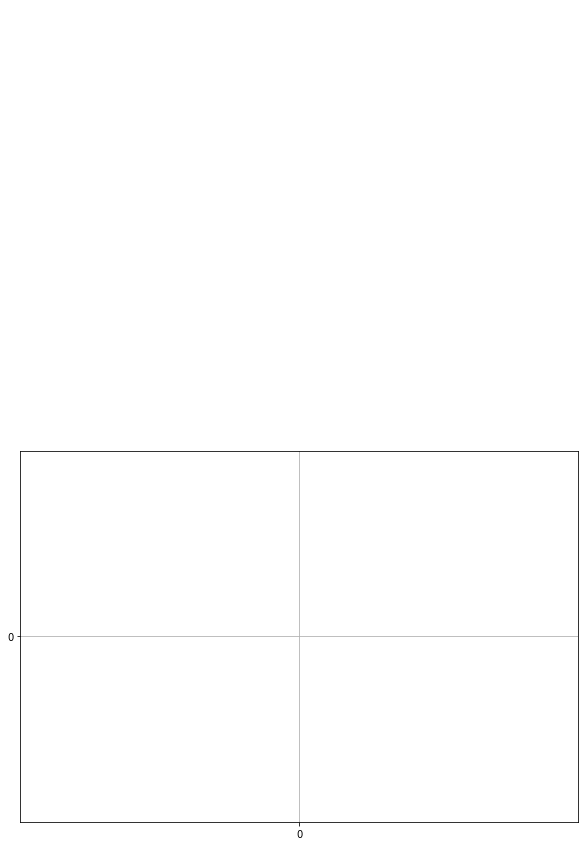

Mean Error Rotation: inf
Mean Error Translation: inf
== [Result] Frame: 0, Matches 0, Inliers: 0.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame000.jpg


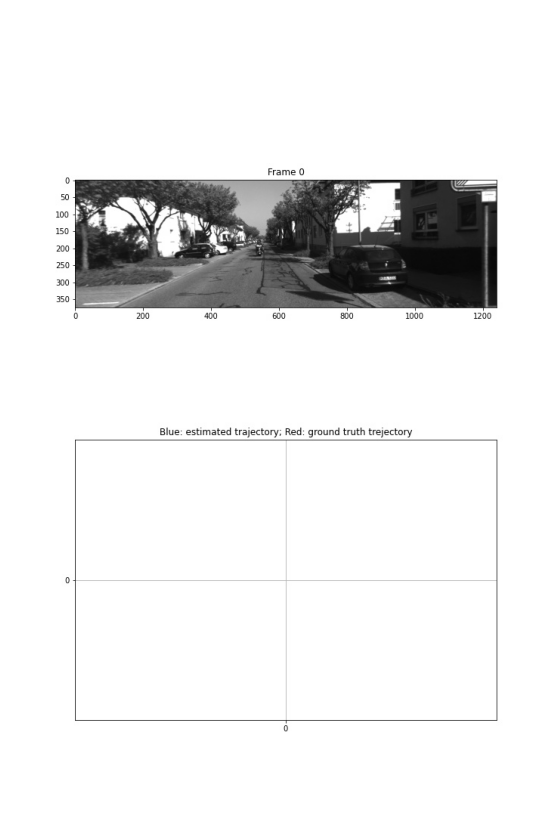

(1463, 4)
[[ 1.     -0.0032 -0.0038  0.001 ]
 [ 0.0032  1.     -0.0021 -0.0071]
 [ 0.0038  0.002   1.      0.4649]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.07540
Mean Error Translation: 97.58477
== [Result] Frame: 1, Matches 1463, Inliers: 97.74


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame001.jpg
(1463, 4)
[[ 1.     -0.0011 -0.0081 -0.0071]
 [ 0.0011  1.     -0.0033 -0.0153]
 [ 0.0081  0.0033  1.      0.9386]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.03963
Mean Error Translation: 48.98556
== [Result] Frame: 2, Matches 1463, Inliers: 96.65


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame002.jpg
(1463, 4)
[[ 0.9999 -0.0001 -0.012  -0.0176]
 [ 0.      1.     -0.0045 -0.0217]
 [ 0.012   0.0045  0.9999  1.4016]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02731
Mean Error Translation: 32.78971
== [Result] Frame: 3, Matches 1463, Inliers: 95.28


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame003.jpg
(1463, 4)
[[ 0.9998  0.0009 -0.0174 -0.0261]
 [-0.001   1.     -0.0049 -0.0278]
 [ 0.0174  0.005   0.9998  1.8681]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02170
Mean Error Translation: 24.69069
== [Result] Frame: 4, Matches 1463, Inliers: 94.60


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame004.jpg
(1463, 4)
[[ 0.9998 -0.0002 -0.0219 -0.0386]
 [ 0.0001  1.     -0.0051 -0.0351]
 [ 0.0219  0.0051  0.9997  2.3425]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01823
Mean Error Translation: 19.82983
== [Result] Frame: 5, Matches 1463, Inliers: 91.73


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame005.jpg
(1463, 4)
[[ 0.9997  0.0022 -0.0261 -0.0588]
 [-0.0024  1.     -0.0061 -0.0426]
 [ 0.0261  0.0062  0.9996  2.8178]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01586
Mean Error Translation: 16.58883
== [Result] Frame: 6, Matches 1463, Inliers: 92.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame006.jpg
(1463, 4)
[[ 0.9995  0.0056 -0.0306 -0.0854]
 [-0.0058  1.     -0.0069 -0.0466]
 [ 0.0306  0.0071  0.9995  3.3064]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01437
Mean Error Translation: 14.27208
== [Result] Frame: 7, Matches 1463, Inliers: 90.29


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame007.jpg
(1463, 4)
[[ 0.9994  0.0078 -0.0341 -0.1167]
 [-0.008   1.     -0.0053 -0.053 ]
 [ 0.034   0.0056  0.9994  3.813 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01319
Mean Error Translation: 12.53209
== [Result] Frame: 8, Matches 1463, Inliers: 90.29


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame008.jpg
(1463, 4)
[[ 0.9993  0.0126 -0.0352 -0.1715]
 [-0.0127  0.9999 -0.0028 -0.0599]
 [ 0.0351  0.0033  0.9994  4.3272]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01260
Mean Error Translation: 11.17798
== [Result] Frame: 9, Matches 1463, Inliers: 90.02


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame009.jpg
(1463, 4)
[[ 0.9992  0.0156 -0.0374 -0.2087]
 [-0.0157  0.9999 -0.0001 -0.0674]
 [ 0.0374  0.0007  0.9993  4.8767]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01199
Mean Error Translation: 10.09120
== [Result] Frame: 10, Matches 1463, Inliers: 89.20


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame010.jpg


FileNotFoundError: [Errno 2] No such file or directory: 'Flow/000011_flow.npy'

In [4]:
import runMatch
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'Flow'
runMatch.runSFM(dataset_path, feature_dir )

Next, answer the following questions:

1. Does SPyNet yield higher accuracy than the original $\mathtt{libviso2}$? If so, why? If not, what steps can you take to improve?1. Does SPyNet yield higher accuracy than the original $\mathtt{libviso2}$? If so, why? If not, what steps can you take to improve?

2. Explain how SPyNet achieves accurate flow with significantly lower computational cost.